In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import PredefinedSplit
import matplotlib.pyplot as plt
import warnings as wr
import seaborn as sns
from scipy.stats import pearsonr
import starbars as sb
from pathlib import Path
from sklearn.utils import resample
from scipy.stats import mannwhitneyu

wr.filterwarnings('ignore')

work_dir = Path.cwd().parent.parent / 'Work'
df_web = pd.read_excel(work_dir / "summary_tests.xlsx")
df_app = pd.read_csv(work_dir / "summary_test.tsv", sep ='\t')

delete_columns_app = ['id_person', 'id_test_attempt']
delete_columns_web = ['id_sample', 'Unnamed: 0']
df_app.drop(columns=delete_columns_app, inplace=True)
df_web.drop(columns=delete_columns_web, inplace=True)
df_app = df_app.drop(df_app.loc[df_app['age'] < 20].index)
df_web = df_web.drop(df_web.loc[df_web['age'] < 20].index)

df_app.loc[df_app['sex'] == 'F', 'sex'] = 1
df_app.loc[df_app['sex'] == 'M', 'sex'] = 0
# print(df_app.shape)
# print(df_web.shape)

# columns_web = set(df_web.columns)
# columns_app = set(df_app.columns)
# if columns_web == columns_app:
#     print('ok')

df_web['source'] = 'Сайт'
df_app['source'] = 'Приложение'
#df_app.to_excel(work_dir / "summary_test_saved.xlsx", index=False)
df_web = df_web[df_web['age'] <= df_app['age'].max()]

bins = [20, 37, 55, 73]

df_web['age_group'] = pd.cut(df_web['age'], bins=bins)
df_app['age_group'] = pd.cut(df_app['age'], bins=bins)
#df_app.to_excel(work_dir / "summary_test_saved_bins.xlsx", index=False)

age_bin_proportions = df_app['age_group'].value_counts(normalize=True)

df_web_sampled = pd.DataFrame()

for age_bin, proportion in age_bin_proportions.items():
    n_samples_bin = int(proportion * len(df_app))
    
    df_bin = df_web[df_web['age_group'] == age_bin]
    
    if len(df_bin) < n_samples_bin:
        sampled_bin = df_bin
    else:
        sampled_bin = resample(df_bin, replace=False, n_samples=n_samples_bin, random_state=42)
    
    df_web_sampled = pd.concat([df_web_sampled, sampled_bin], ignore_index=True)


print(f"\nРазмер исходной выборки df_web: {df_web.shape}")
print(f"Размер подвыборки df_web_sampled: {df_web_sampled.shape}")

print("\nРаспределение df_app:")
print(df_app['age'].value_counts(bins=bins, normalize=True))

print("\nРаспределение df_web_sampled:")
print(df_web_sampled['age'].value_counts(bins=bins, normalize=True))

df = pd.concat([df_app, df_web], ignore_index=True)
columns = ['source'] + [col for col in df.columns if col != 'source']
df = df[columns]

#df.to_excel(work_dir / "summary_tests_combined.xlsx", index=False)


Размер исходной выборки df_web: (3020, 307)
Размер подвыборки df_web_sampled: (68, 307)

Распределение df_app:
(19.999, 37.0]    0.617647
(37.0, 55.0]      0.235294
(55.0, 73.0]      0.147059
Name: proportion, dtype: float64

Распределение df_web_sampled:
(19.999, 37.0]    0.617647
(37.0, 55.0]      0.235294
(55.0, 73.0]      0.147059
Name: proportion, dtype: float64


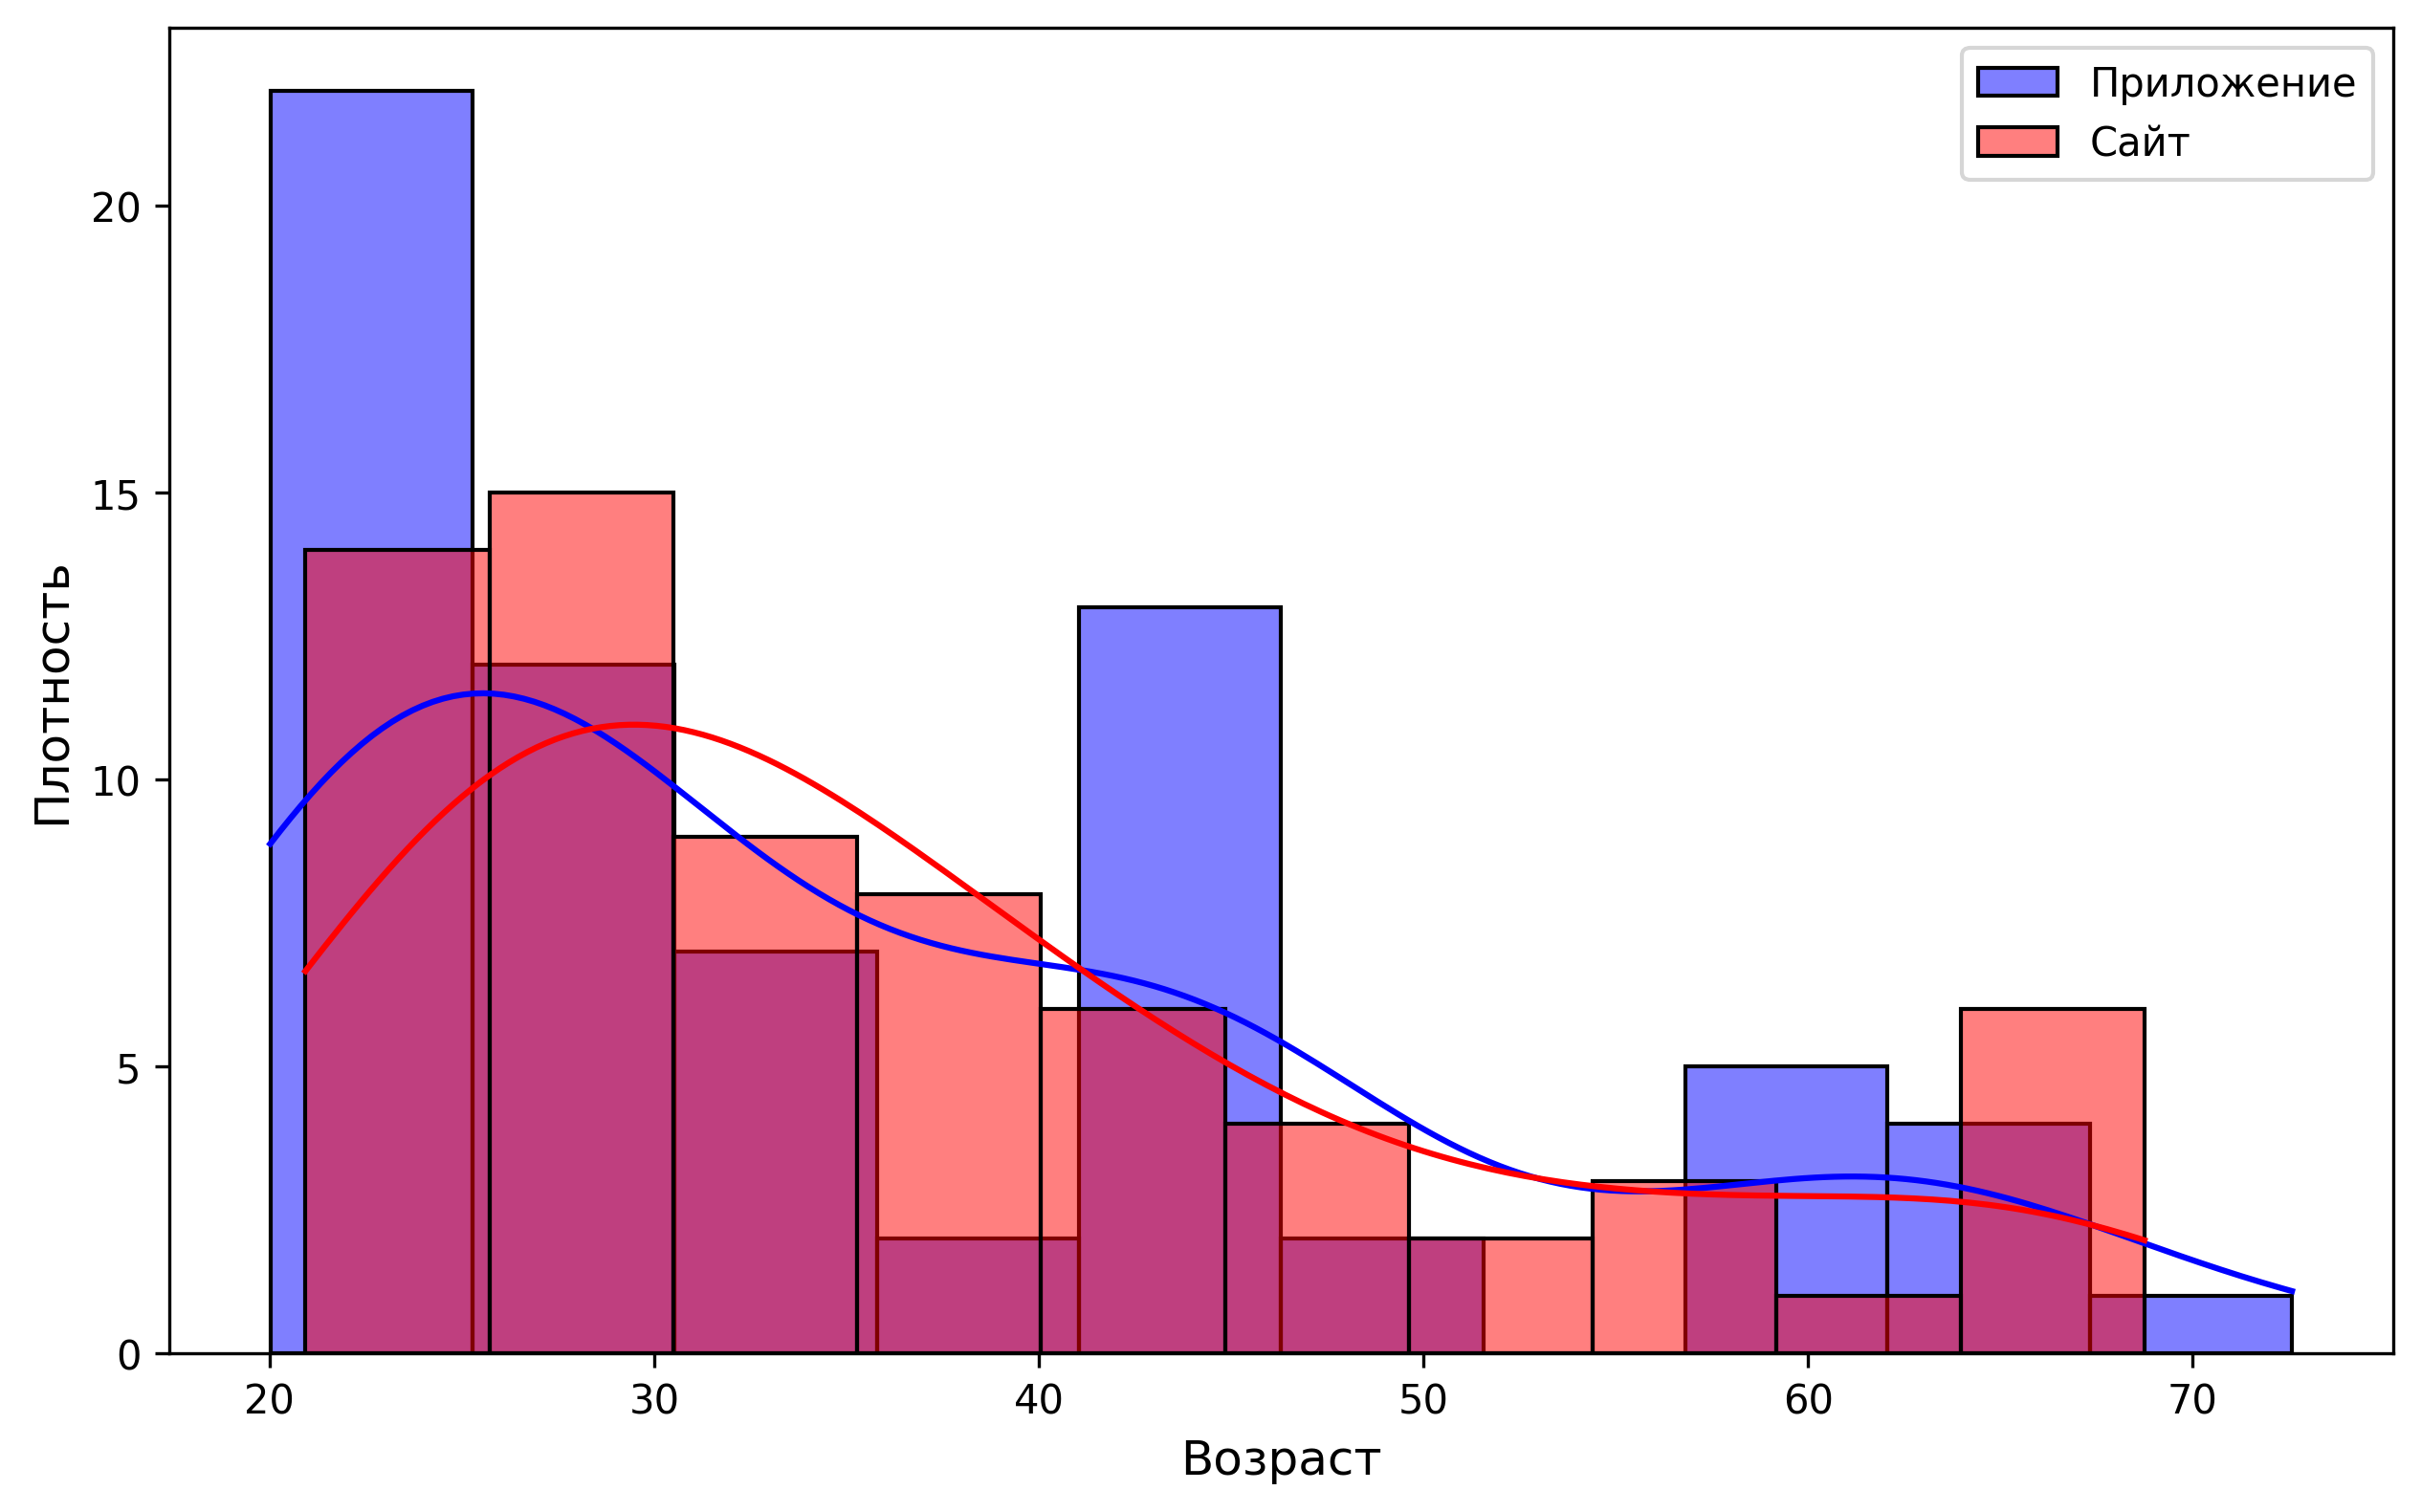

In [2]:
plt.figure(figsize=(10, 6), dpi=300)

sns.histplot(df_app['age'], bins=10, kde=True, color='blue', label='Приложение')
sns.histplot(df_web_sampled['age'], bins=10, kde=True, color='red', label='Сайт')

plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend()
plt.show()

In [3]:
save_dir = work_dir / 'Sets_Compare'
save_dir.mkdir(parents=True, exist_ok=True)

sets_diff = []

def get_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

def is_dir_not_empty(dir):
    return any(dir.iterdir())

def delete_files_in_dir(dir):
    for file in dir.glob('*'):
        if file.is_file():
            file.unlink() 

if is_dir_not_empty(save_dir):
    delete_files_in_dir(save_dir)

features = df.select_dtypes(include=[np.number]).columns.tolist()
features.remove('age') 
def get_quantile(dataFrame, column, percent):
    return dataFrame[column].quantile(percent)

for feature in features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), dpi=300)
    ax1 = axes[0]
    ax1 = sns.boxplot(
        data=df, 
        x='source', 
        y=feature, 
        palette={'Приложение': 'skyblue', 'Сайт': 'lightcoral'},
        ax=ax1
    )
    y_max = get_quantile(df, feature, 0.995)
    y_min = get_quantile(df, feature, 0.005)
    ax1.set_ylim(ymin=y_min, ymax=y_max)
    ax1.set_xlabel('Источник')
    ax1.set_ylabel(feature)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    app_values = df[df['source'] == 'Приложение'][feature].dropna()
    web_values = df[df['source'] == 'Сайт'][feature].dropna()
    stat, p = mannwhitneyu(app_values, web_values)

    sets_diff.append({'Признак': feature, 'p_value': f"{p:.3e}", 'stars': get_stars(p)})

    if p < 0.05:
        sb.draw_annotation([('Приложение', 'Сайт', p)], ax=ax1)

    ax2 = axes[1]
    sns.violinplot(
        data=df, 
        x='source', 
        y=feature, 
        palette={'Приложение': 'skyblue', 'Сайт': 'lightcoral'},
        ax=ax2
    )
    ax2.set_ylim(ymin=y_min, ymax=y_max)
    ax2.set_xlabel('Источник')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)

    if p < 0.05:
        sb.draw_annotation([('Приложение', 'Сайт', p)], ax=ax2)

    plt.tight_layout()
    
    path = save_dir / f'{feature}.png'
    plt.savefig(path, bbox_inches='tight')
    plt.close()

# sets_diff_df = pd.DataFrame(sets_diff)
# sets_diff_df.to_excel(work_dir / 'sets_diff.xlsx', index=False)


2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2.0 0.03
2